In [1]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import pickle
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

/Users/stj/miniconda3/envs/pytorch/lib/python3.6/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load precompiled drug/side effect vectors
with open('sample.pkl', 'rb') as f:
    result = pickle.load(f)
    
print(result.keys())

dict_keys(['train_mask', 'test_mask', 'alpha', 'sample_weight', 'pred', 'true', 'train_score', 'test_score', 'drug_score', 'drug_vec', 'side_vec'])


In [3]:
# ATC code for 750 drugs
drug_names = []
drug_ids = []
drug_atcs = ['XXXXXXX'] * 750

with open('data/drug_id.csv') as f:
    l = f.readline()
    while l:
        drug_name, drug_id = l.split('\n')[0].split(',')
        drug_names.append(drug_name)
        drug_ids.append(drug_id)
        l = f.readline()

with open('data/drug_atc.tsv') as f:
    l = f.readline()
    while l:
        drug_id, drug_atc = l.split('\n')[0].split('\t')

        after = 0
        while drug_id in drug_ids[after:]:
            index = after + drug_ids[after:].index(drug_id)
            drug_atcs[index] = drug_atc
            after = index + 1
        l = f.readline()
        
drug_atcs[642] = 'V10XX03' # https://en.wikipedia.org/wiki/Radium-223

In [4]:
# Organ class for 994 side effects
side_names = []

with open('data/side_effect.csv') as f:
    l = f.readline()
    while l:
        side_name = l.split('\n')[0]
        side_names.append(side_name)
        l = f.readline()
        
df = {
    'soc': pd.read_csv('data/soc.asc', sep='$', header=None, index_col=0),
    'hlgt': pd.read_csv('data/hlgt.asc', sep='$', header=None, index_col=0),
    'hlt': pd.read_csv('data/hlt.asc', sep='$', header=None, index_col=0),
    'pt': pd.read_csv('data/pt.asc', sep='$', header=None, index_col=0),
    'llt': pd.read_csv('data/llt.asc', sep='$', header=None, index_col=0),
}

soc_hlgt = pd.read_csv('data/soc_hlgt.asc', sep='$', header=None)
hlgt_hlt = pd.read_csv('data/hlgt_hlt.asc', sep='$', header=None)
hlt_pt = pd.read_csv('data/hlt_pt.asc', sep='$', header=None)

soc = df['soc'][1].to_dict()
hlgt = df['hlgt'][1].to_dict()
hlt = df['hlt'][1].to_dict()
pt = df['pt'][1].to_dict()
llt = df['llt'][1].to_dict()

soc_hlgt = soc_hlgt[[0, 1]]
hlgt_hlt = hlgt_hlt[[0, 1]]
hlt_pt = hlt_pt[[0, 1]]
llt_pt = df['llt'][2].reset_index()
pt_soc = df['pt'][3].reset_index()

side_llt = [0] * 994
side_pt = [0] * 994
side_hlt = [0] * 994
side_hlgt = [0] * 994
side_soc = [0] * 994

for llt_id in llt:
    if llt[llt_id].lower() in side_names:
        side_index = side_names.index(llt[llt_id].lower())
        side_llt[side_index] = llt_id
        side_pt[side_index] = llt_pt[llt_pt[0] == llt_id][2].values[0]
        pt_id = side_pt[side_index]
        side_soc[side_index] = pt_soc[pt_soc[0] == pt_id][3].values[0]

side_soc = list(map(lambda t: soc[t], side_soc))

In [5]:
# stack drug vectors and side effect vectors
ds = np.vstack((result['drug_vec'], result['side_vec']))

In [18]:
# PCA transformation for visualization
pca = PCA(n_components=2)
pca_ds = pca.fit_transform(ds)

# full names for ATC codes and side effects
atcs = {
    'A': 'Alimentary tract and metabolism', 
    'B': 'Blood and blood forming organs', 
    'C': 'Cardiovascular system', 
    'D': 'Dermatologicals', 
    'G': 'Genito-urinary system and sex hormones', 
    'H': 'Systemic hormonal preparations, excluding sex hormones and insulins', 
    'J': 'Antiinfectives for systemic use', 
    'L': 'Antineoplastic and immunomodulating agents',
    'M': 'Musculo-skeletal system', 
    'N': 'Nervous system', 
    'P': 'Antiparasitic products, insecticides and repellents',
    'R': 'Respiratory system',  
    'S': 'Sensory organs', 
    'V': 'Various', 
}

organs = '''Metabolism and nutrition disorders
Hepatobiliary disorders
Gastrointestinal disorders
Blood and lymphatic system disorders
Vascular disorders
Cardiac disorders
Skin and subcutaneous tissue disorders
Renal and urinary disorders
Reproductive system and breast disorders
Pregnancy, puerperium and perinatal conditions
Endocrine disorders
Infections and infestations
Immune system disorders
Neoplasms benign, malignant and unspecified (incl cysts and polyps)
Musculoskeletal and connective tissue disorders
Psychiatric disorders
Nervous system disorders
Respiratory, thoracic and mediastinal disorders
Ear and labyrinth disorders
Eye disorders
General disorders and administration site conditions
Investigations
Surgical and medical procedures
Social circumstances
Congenital, familial and genetic disorders
Injury, poisoning and procedural complications'''.split('\n')

In [7]:
# color palette for better visualization
color_palette = {
    'A': '#2f912f', 
    'B': '#8b1a1a', 
    'C': '#df2c50', 
    'D': '#fee5bb', 
    'G': '#fd2a9c', 
    'H': '#f18d8d', 
    'J': '#767676', 
    'L': '#28fefe',
    'M': '#0c0c0c', 
    'N': '#fff82d', 
    'P': '#26ff19',
    'R': '#1b1bff',  
    'S': '#9e1ae1', 
    'V': '#8b8b17',
    
    'Metabolism and nutrition disorders': '#9ac29a',
    'Hepatobiliary disorders': '#26ff8b',
    'Gastrointestinal disorders': '#399739',
    'Blood and lymphatic system disorders': '#8b1a1a',
    'Vascular disorders': '#b74470',
    'Cardiac disorders': '#dd1d43',
    'Skin and subcutaneous tissue disorders': '#fee5bc',
    'Renal and urinary disorders': '#d29153',
    'Reproductive system and breast disorders': '#fec5c9',
    'Pregnancy, puerperium and perinatal conditions': '#fd2c9d',
    'Endocrine disorders': '#f18c8c',
    'Infections and infestations': '#6f6f6f',
    'Immune system disorders': '#1ec5ff',
    'Neoplasms benign, malignant and unspecified (incl cysts and polyps)': '#28fefe',
    'Musculoskeletal and connective tissue disorders': '#1a1a1a',
    'Psychiatric disorders': '#fdac13',
    'Nervous system disorders': '#fff710',
    'Respiratory, thoracic and mediastinal disorders': '#1919ff',
    'Ear and labyrinth disorders': '#5a5096',
    'Eye disorders': '#9d17d6',
    'General disorders and administration site conditions': '#87870e',
    'Investigations': '#b5ff45',
    'Surgical and medical procedures': '#339aff',
    'Social circumstances': '#8270ee',
    'Congenital, familial and genetic disorders': '#e0a9e0',
    'Injury, poisoning and procedural complications': '#961a96',
    
    'default': '#d4d4d4',
}

In [8]:
# draw ellipses
# source: https://scipython.com/book/chapter-7-matplotlib/examples/bmi-data-with-confidence-ellipses/
def get_cov_ellipse(cov, centre, nstd, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)

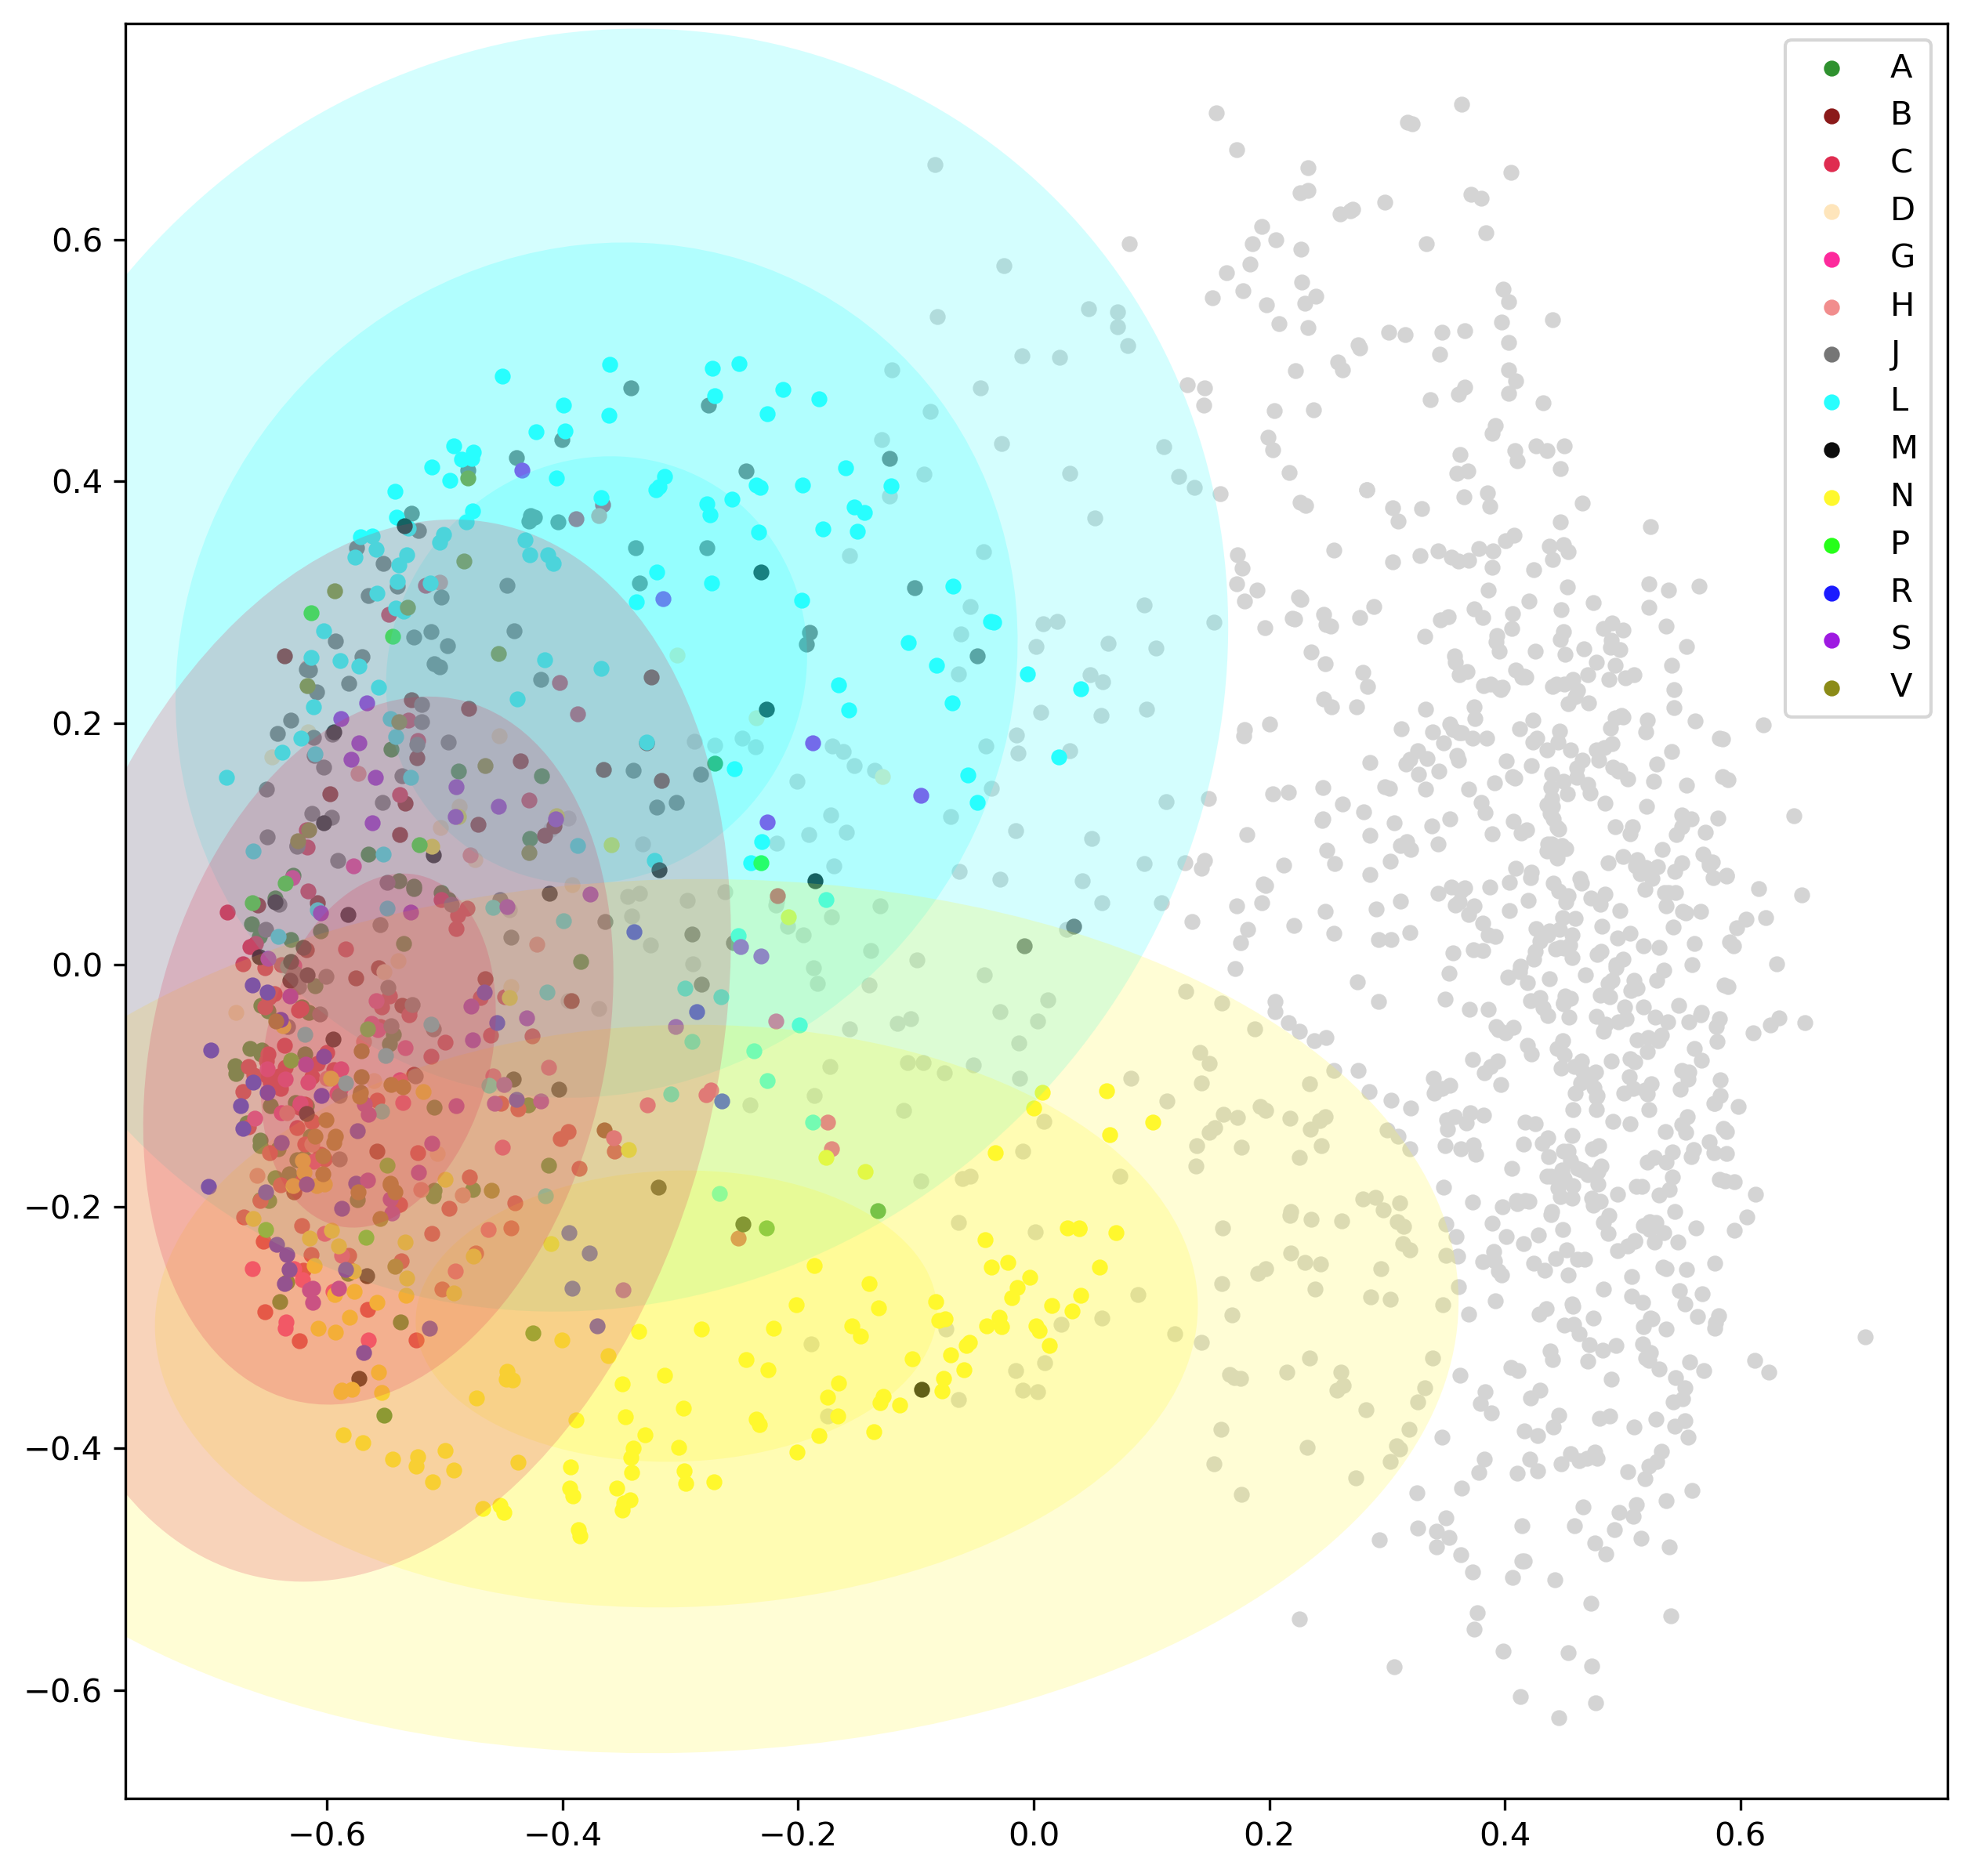

In [21]:
# drug-oriented
legend = []
plt.figure(figsize=(10, 10))

for i in range(len(organs)):
    label = organs[i].split(' ')[0]
    index = np.array(list(filter(lambda t: side_soc[t] == organs[i], np.arange(994).tolist()))) + 750
    color = color_palette['default']
    plt.scatter(pca_ds[index, 0], pca_ds[index, 1], s=15, c=color)

for i in range(len(atcs)):
    label = list(atcs.keys())[i][0]
    index = list(filter(lambda t: drug_atcs[t][0] == list(atcs.keys())[i], np.arange(750).tolist()))
    color = color_palette[label]
    legend.append(label)
    plt.scatter(pca_ds[index, 0], pca_ds[index, 1], s=15, c=color)

plt.legend(legend)
ax = plt.gca()
leg = ax.get_legend()

for i in range(len(atcs)):
    leg.legendHandles[i].set_color(color_palette[list(atcs.keys())[i][0]])

ellipses = ['L', 'N', 'C']

for e in ellipses:
    if e in atcs.keys():
        index = list(filter(lambda t: drug_atcs[t][0] == e, np.arange(750).tolist()))
    elif e in organs:
        index = list(filter(lambda t: side_soc[t] == e, np.arange(994).tolist()))
        
    color = color_palette[e]
    cov = np.cov(pca_ds[index, 0], pca_ds[index, 1])

    for std in range(1, 4):
        e = get_cov_ellipse(cov, (pca_ds[index, 0].mean(), pca_ds[index, 1].mean()), std, fc=color, alpha=0.2)
        ax.add_artist(e)

plt.show()

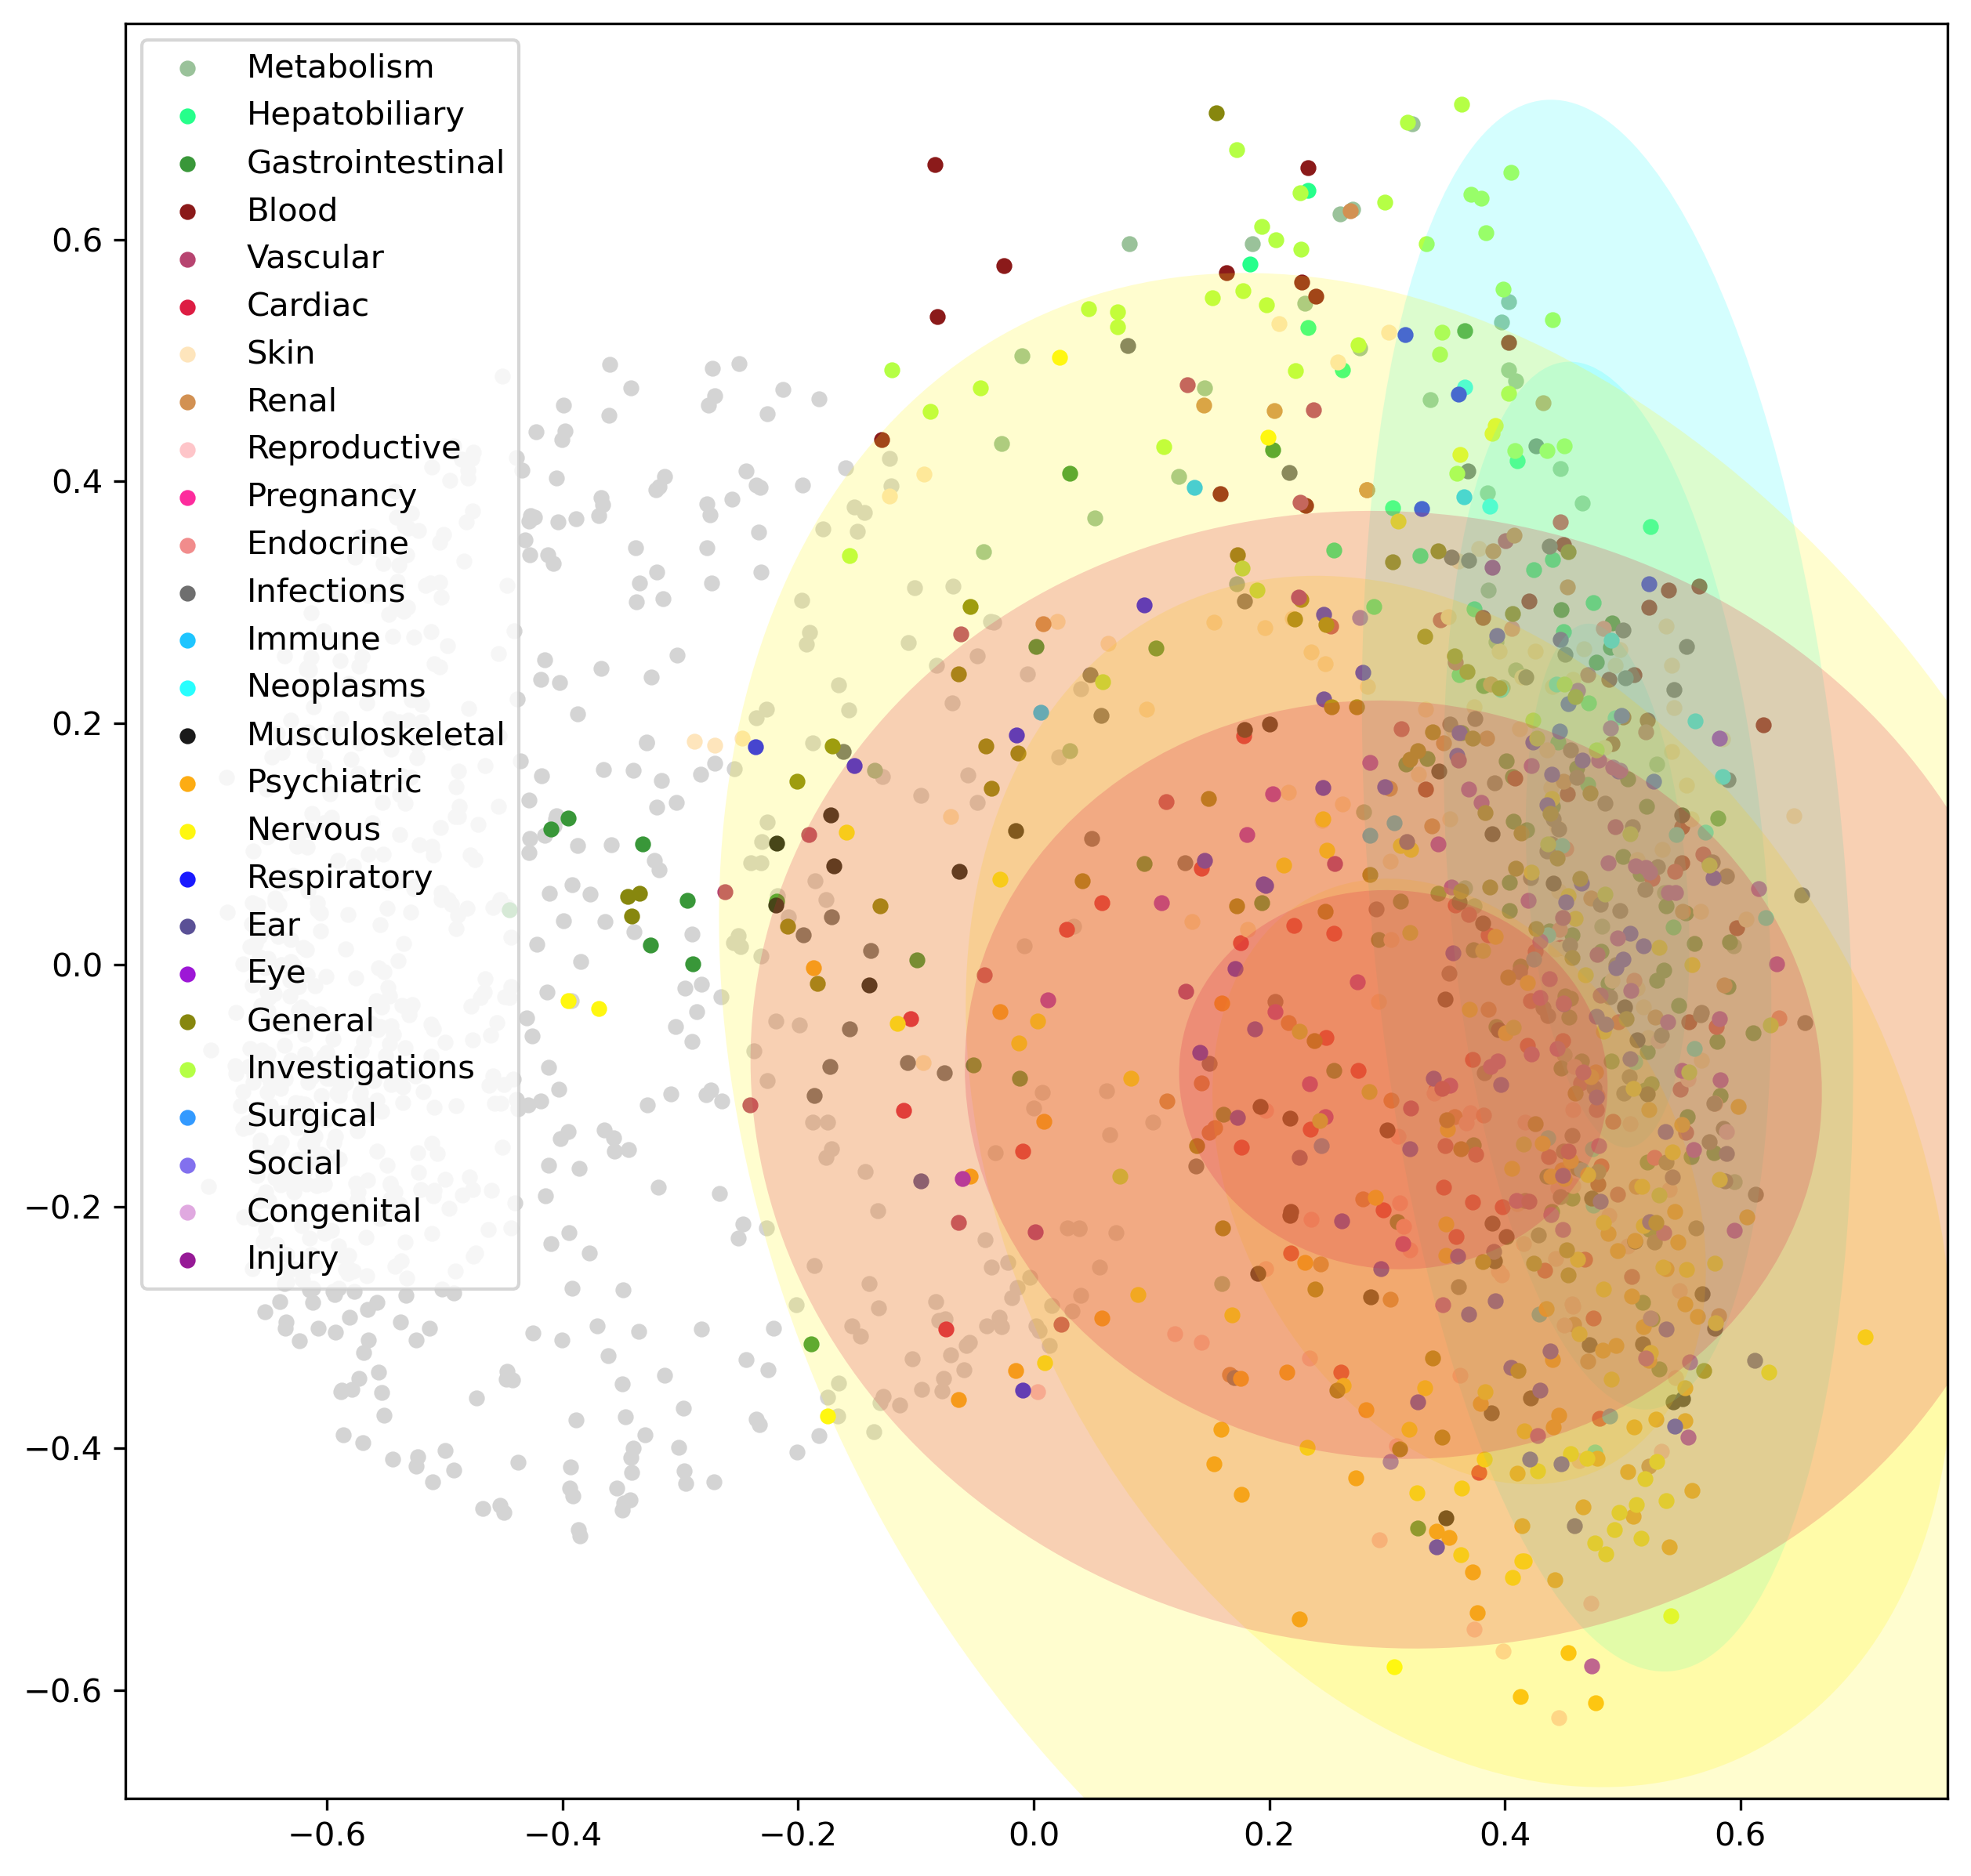

In [22]:
# side effect-oriented
legend = []
plt.figure(figsize=(10, 10))

for i in range(len(atcs)):
    label = list(atcs.keys())[i][0]
    index = list(filter(lambda t: drug_atcs[t][0] == list(atcs.keys())[i], np.arange(750).tolist()))
    color = color_palette['default']
    plt.scatter(pca_ds[index, 0], pca_ds[index, 1], s=15, c=color)


for i in range(len(organs)):
    label = organs[i].split(' ')[0]
    index = np.array(list(filter(lambda t: side_soc[t] == organs[i], np.arange(994).tolist()))) + 750
    color = color_palette[organs[i]]
    legend.append(label.split(',')[0])
    plt.scatter(pca_ds[index, 0], pca_ds[index, 1], s=15, c=color)

plt.legend(legend, loc='upper left')
ax = plt.gca()
leg = ax.get_legend()

for i in range(len(organs)):
    leg.legendHandles[i].set_color(color_palette[organs[i]])

ellipses = [
    'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
    'Nervous system disorders',
    'Cardiac disorders',
]

for e in ellipses:
    if e in atcs.keys():
        index = list(filter(lambda t: drug_atcs[t][0] == e, np.arange(750).tolist()))
    elif e in organs:
        index = np.array(list(filter(lambda t: side_soc[t] == e, np.arange(994).tolist()))) + 750
        
    color = color_palette[e]
    cov = np.cov(pca_ds[index, 0], pca_ds[index, 1])

    for std in range(1, 4):
        e = get_cov_ellipse(cov, (pca_ds[index, 0].mean(), pca_ds[index, 1].mean()), std, fc=color, alpha=0.2)
        ax.add_artist(e)
    
plt.show()

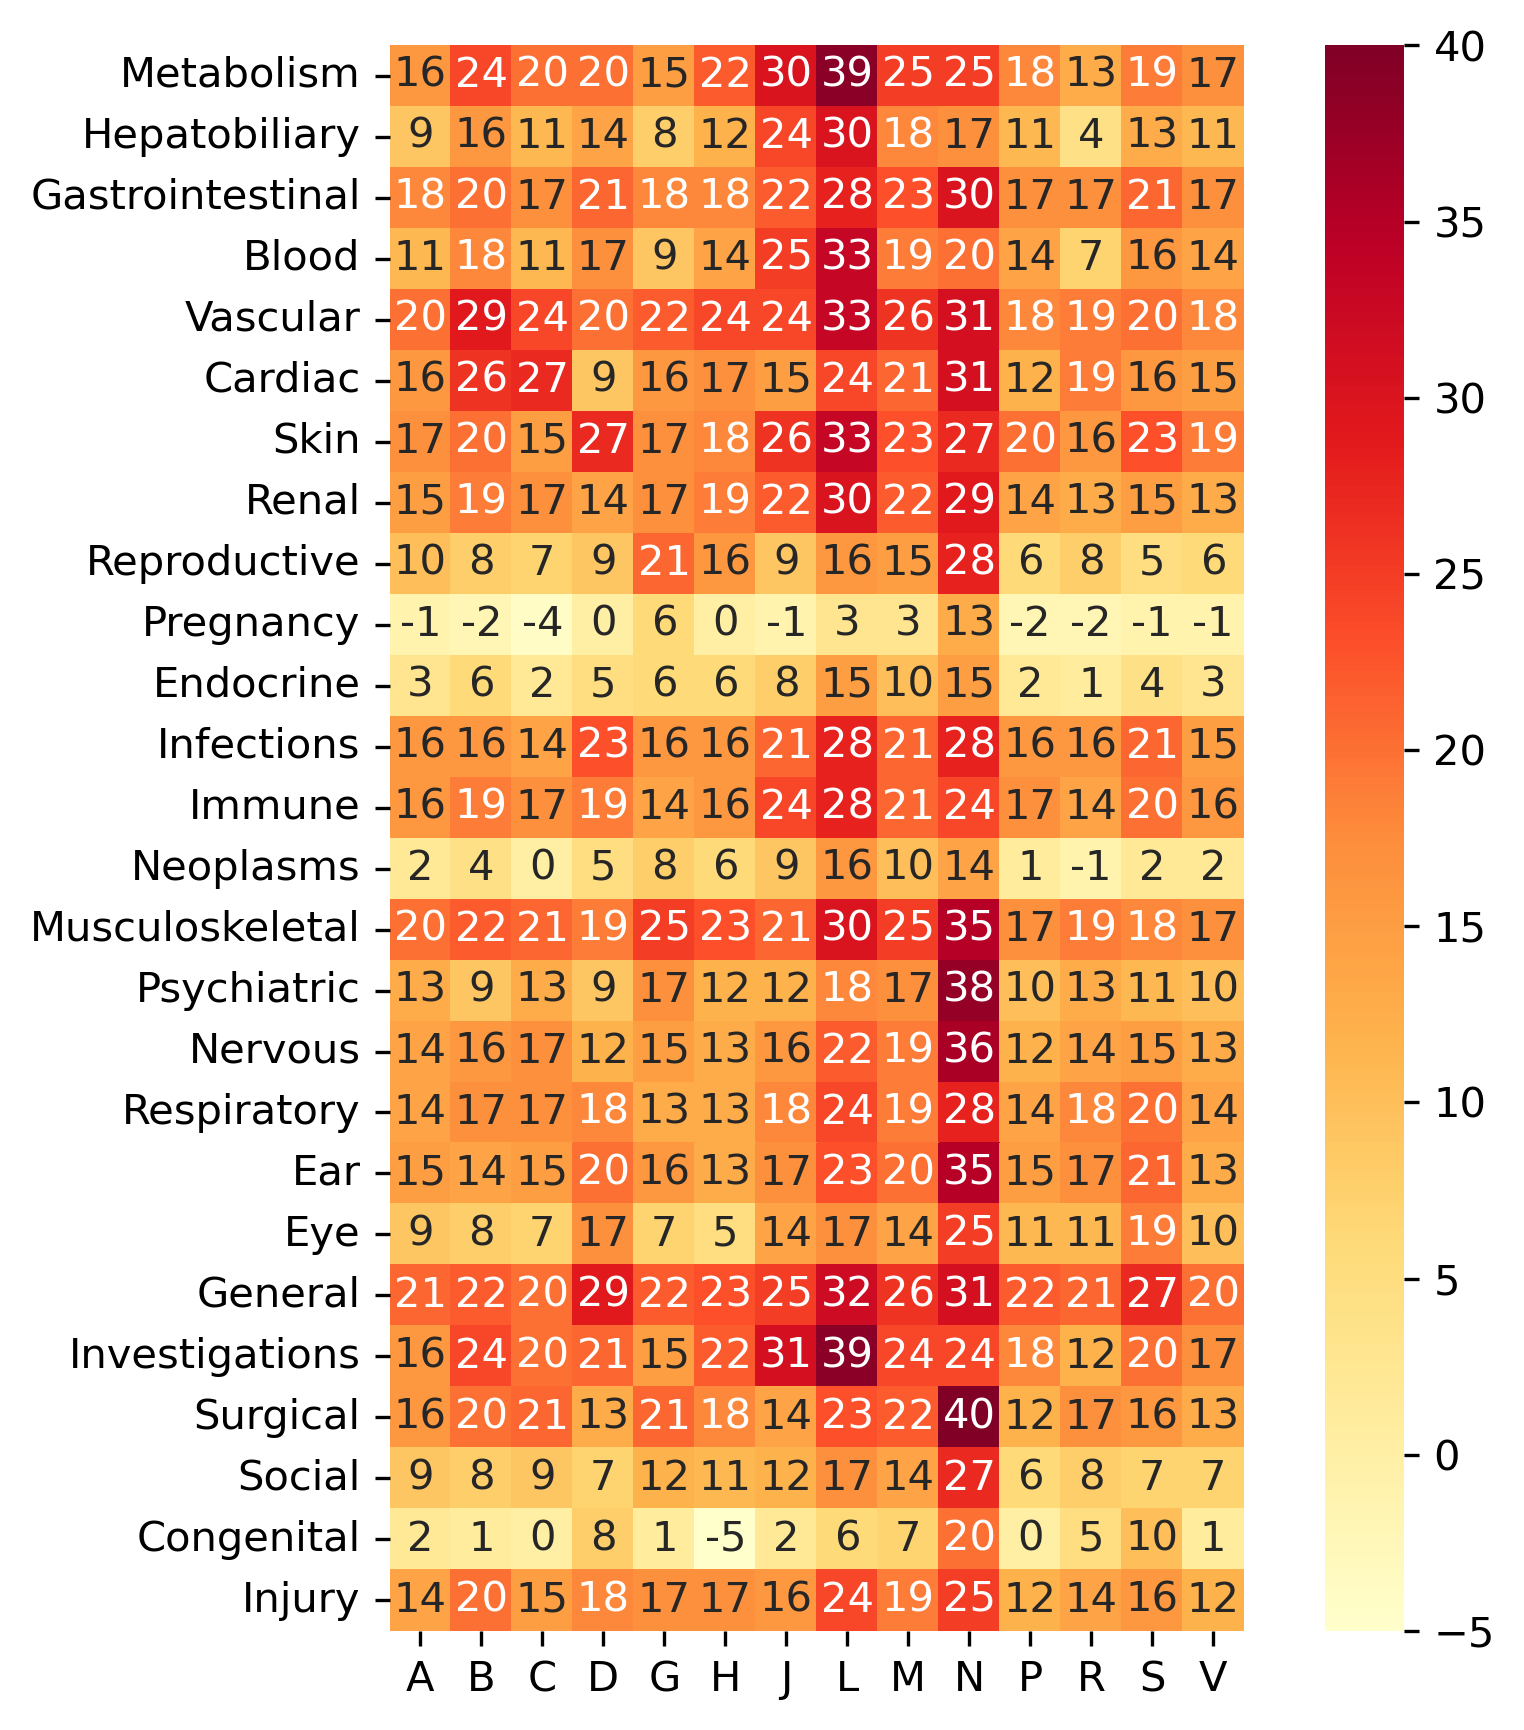

In [23]:
# similarity matrix
cosine_similarity = np.random.random((len(organs), len(atcs)))

for i in range(len(atcs)):
    for j in range(len(organs)):
        atc_drugs = ds[list(filter(lambda t: drug_atcs[t][0] == list(atcs.keys())[i], np.arange(750).tolist()))]
        organ_sides = ds[np.array(list(filter(lambda t: side_soc[t] == organs[j], np.arange(994).tolist()))) + 750]
        
        cosine_similarity[j][i] = np.matmul(atc_drugs, organ_sides.T).mean()

        
cosine_similarity = (cosine_similarity * 100).astype(np.int_)

plt.figure(figsize = (7,7))
sns.heatmap(
    cosine_similarity,
    annot=True,
    cmap="YlOrRd",
    xticklabels=list(atcs.keys()),
    yticklabels=list(map(lambda t: t.split(' ')[0].split(',')[0], organs)),
    square=True
    )

plt.show()

In [24]:
# targeted and cytotoxic drugs
# source: https://www.cancerrxgene.org/gdsc1000/GDSC1000_WebResources/Data_Summary.html
targeted_drugs = [68, 327, 346, 351, 381, 519, 522, 549, 563, 585, 591, 598, 599, 609, 616, 621, 622, 631, 656, 678, 679, 691, 693, 721, 725, 728, 735, 741]
cytotoxic_drugs = [11, 23, 144, 155, 170, 185, 245, 296, 355, 395, 510]

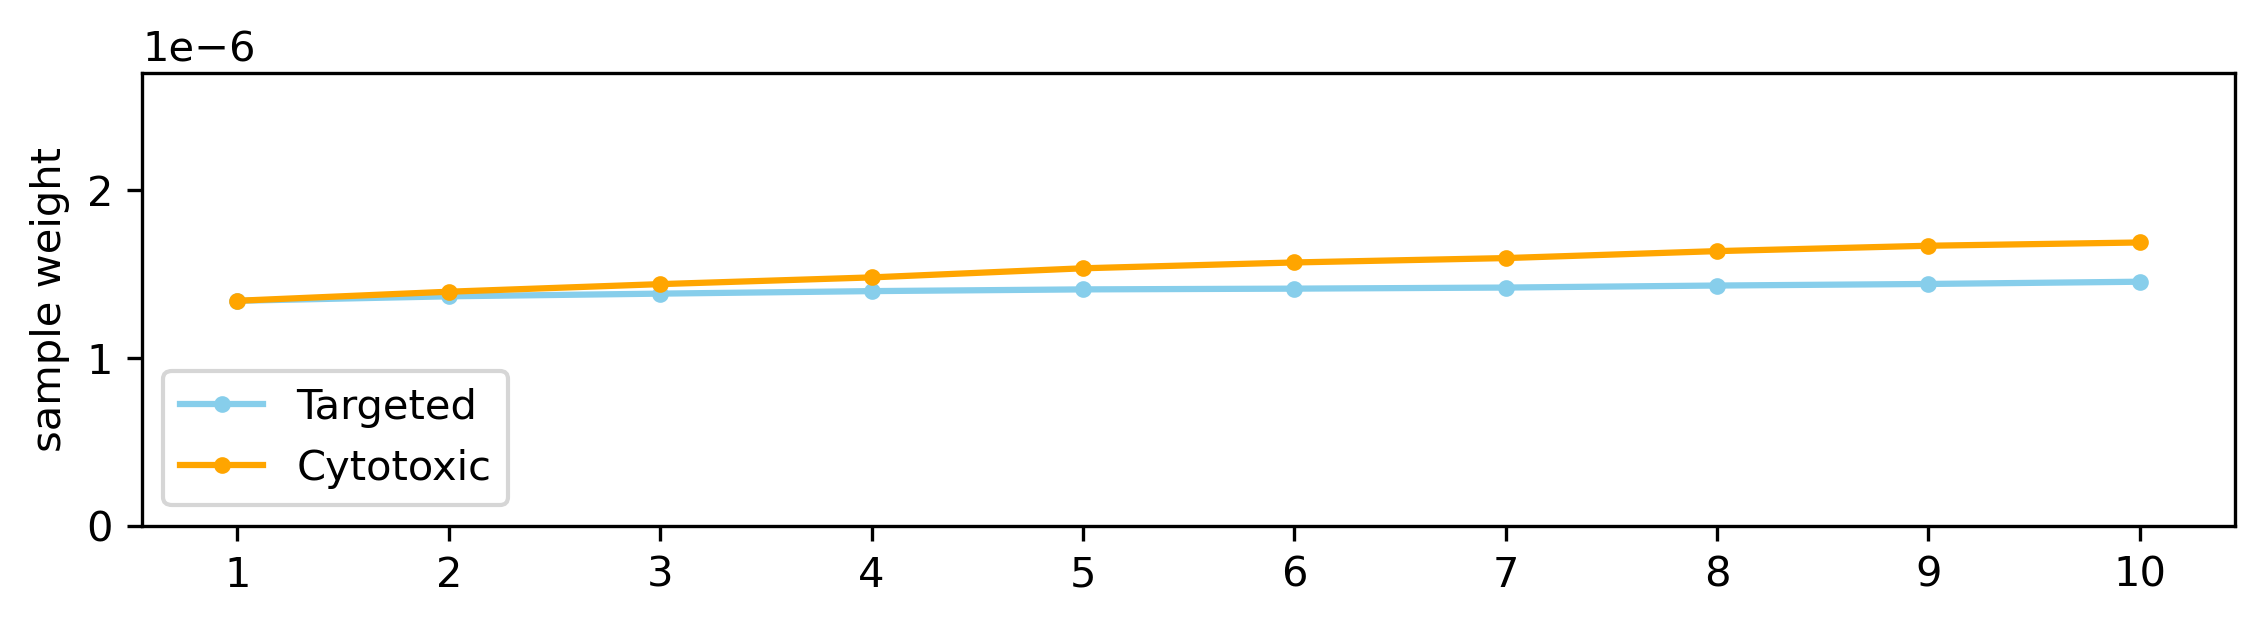

In [25]:
# data sampling weights per Adaboost
weight = result['sample_weight']

plt.figure(figsize=(9, 2))
plt.ylim(bottom=0, top=2.7e-6)

t_ = weight[:, targeted_drugs, :].mean(axis=1)
c_ = weight[:, cytotoxic_drugs, :].mean(axis=1)

plt.plot(np.arange(10), t_.mean(axis=1), label='Targeted', color='skyblue', marker='.')
plt.plot(np.arange(10), c_.mean(axis=1), label='Cytotoxic', color='orange', marker='.')
plt.fill_between(np.arange(10), t_.mean(axis=1)-t_.std(axis=1), t_.mean(axis=1)+t_.std(axis=1), facecolor='blue', alpha=0.9)
plt.fill_between(np.arange(10), c_.mean(axis=1)-c_.std(axis=1), c_.mean(axis=1)+c_.std(axis=1), facecolor='blue', alpha=0.9)

plt.xticks(ticks=np.arange(10), labels=1+np.arange(10))
plt.ylabel('sample weight')

plt.legend(loc='lower left')
plt.show()

In [ ]:

metric = 'auc'
perf = result['drug_score'][metric]
n_boost = perf.shape[0] / 2

plt.figure(figsize=(9, 2))
plt.plot(np.arange(10), perf[:10, np.array(targeted_drugs)].mean(axis=1), color='skyblue', alpha=.4, marker='.', linestyle='--')
plt.plot(np.arange(10), perf[:10, np.array(cytotoxic_drugs)].mean(axis=1), color='orange', alpha=.3, marker='.', linestyle='--')
plt.plot(np.arange(10), perf[10:, np.array(targeted_drugs)].mean(axis=1), label='Targeted', color='skyblue', marker='.', linestyle='-')
plt.plot(np.arange(10), perf[10:, np.array(cytotoxic_drugs)].mean(axis=1), label='Cytotoxic', color='orange', marker='.', linestyle='-')

plt.xticks(ticks=np.arange(10), labels=1+np.arange(10))
plt.ylabel('AUC')
plt.legend(loc='lower left')
plt.show()

print(
    perf[10:, np.array(targeted_drugs)].mean(axis=1)[9] - perf[10:, np.array(targeted_drugs)].mean(axis=1)[0],
    perf[10:, np.array(cytotoxic_drugs)].mean(axis=1)[9] - perf[10:, np.array(cytotoxic_drugs)].mean(axis=1)[0],
)